#### Project notes based on other presentations
- Have a conservation check for each run
- show diagram of grid
- insert CFL condition
- grid sensitivity study
- mention the grids and discretizations
- mention bugs or issues you ran into
- mathematical introduction before discretization

In [1312]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('./assets/custom.mplstyle')

#### Grid indexing philosophy

`j` corresponds to the y-axis \
`i` corresponds to the x-axis

#### Grid basis setup

In [1313]:
# Define grid point parameters
x_min, x_max = [0, 1]
z_min, z_max = [0, 1]
dx, dz = 0.25, 0.25
# Define base grid basis "vectors" (bv) to outline grid formation (step size added to maximum bound to include it)
bv_base_x = np.arange(x_min, x_max+dx, dx)
bv_base_z = np.arange(z_min, z_max+dz, dz)
# Build base grid meshgrid
base_x, base_z = np.meshgrid(bv_base_x, bv_base_z)

# CFL number
cfl = 0.5
# Timestep (assume c = 1)
dt = cfl*dx

#### Grid plotting

Text(0, 0.5, 'z')

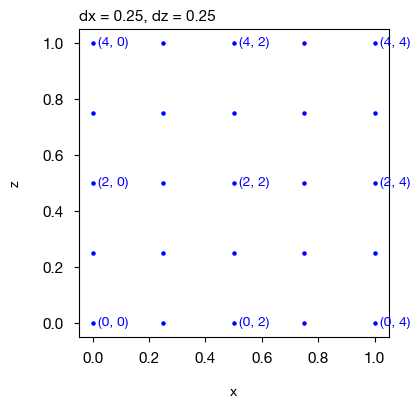

In [1314]:
fig, ax = plt.subplots(figsize=(4, 4))
im_base = ax.scatter(base_x, base_z, s=5)

point_labels = True

# Annotate grid points for troubleshooting
if point_labels == True:
    # Choose type of annotation for point labels [index = (i, j) space, absolute = (x, y) space]
    point_label_type = 'index' # choose 'index' or 'absolute'
    point_label_skip = 2 # print grid point label every N points
    for j, z in enumerate(base_z):
        for i, x in enumerate(base_x):
            point_label = '({0}, {1})'.format(j, i) if point_label_type == 'index' else '({0:.1f}, {1:.1f})'.format(x[i], z[j])
            if j % point_label_skip == 0 and i % point_label_skip == 0:
                ax.annotate(point_label, (x[i], z[j]), xytext=(x[i] + 0.02, z[j] - 0.01), fontsize=10, c='b')

# Axis properties
# ax.set_xlim([base_x.min(), base_x.max()])
# ax.set_ylim([base_z.min(), base_z.max()])
# Axis title
ax_title_str = 'dx = {0}, dz = {1}'.format(dx, dz)
ax.set_title(label=ax_title_str)
ax.set_xlabel('x')
ax.set_ylabel('z')

#### First-pass discretization
__Spatial__: 2nd-order centered difference, B-grid (u, w on the 1/2 points, $\rho$ on the integer points) \
__Temporal__: forward Euler

In [1310]:
def disc_(fields, refs, dx, dz, dt):
    
    # Load reference values
    rho_0, p_0_ = refs
    # Load current values (n)
    x, z, rho, p, u, w = fields
    
    # Initialize new values (n+1 represented by _n)
    rho_n = np.full(shape=(len(z), len(x)), fill_value=np.nan, dtype=float)
    p_n = np.full(shape=(len(z), len(x)), fill_value=np.nan, dtype=float)
    u_n = np.full(shape=(len(z), len(x)), fill_value=np.nan, dtype=float)
    w_n = np.full(shape=(len(z), len(x)), fill_value=np.nan, dtype=float)
    
    for j in range(0, len(z)):
        for i in range(0, len(x)):
            
            # Create modulo-based indices for lateral doubly-periodic conditions
            l, r = (i-1) % len(x), (i+1) % len(x) # left (l) and right (r)
        
            # Get reference pressure at point
            p_0 = p_0_[j, i]
            
            print(p_0)
        
            # Handle bottom boundary condition.
            if j == 0:
                
                print('\t ({0:2}, {1:2}) | left/right/ups: {2} | u: {3:3.3f}, w: {4:3.3f}, rho: {5:3.3f}, p: {6:3.3f}'.format(i, j, (l, r, j+1, j+2), u[j, i], w[j, i], rho[j, i], p[j, i]))
                
                # Second-order forward finite difference methods used for lower boundary
                
                # Step horizontal velocity in time - revisit indexing for velocity updates
                du_dx = (u[j, r] - u[j, l])/(2*dx)
                du_dz = (-3*u[j, i] + 4*u[j+1, i] - u[j+2, i])/(2*dz)
                dphi_dx = ((p[j, r]-p_0) - (p[j, l]-p_0))/(2*dx)
                u_n[j, i] = u[j, i] + dt*(-u[j, i]*du_dx - w[j, i]*du_dz + dphi_dx/rho_0)
                
                # Step vertical velocity in time - revisit indexing for velocity updates
                dw_dx = (w[j, r] - w[j, l])/(2*dx)
                dw_dz = (-3*w[j, i] + 4*w[j+1, i] - w[j+2, i])/(2*dz)
                dphi_dz = (-3*(p[j, i]-p_0) + 4*(p[j+1, i]-p_0) - (p[j+2, i]-p_0))/(2*dz)
                
                w_n[j, i] = w[j, i] + dt*(-u[j, i]*dw_dx - w[j, i]*dw_dz - dphi_dz/rho_0 - g*(rho[j, i] - rho_0)/rho_0)
                
                # Why is w nonzero everywhere on the first row?
                print('\t \t w: {0:5.3f}, u(dw/dx): {1:5.3f}, w(dw/dz): {2:5.3f}, dphi/dz: {3:5.3f}, b: {4:5.3f}, w_n: {5:5.3f}'.format(w[j, i], -u[j, i]*dw_dx, w[j, i]*dw_dz, dphi_dz/rho_0, g*(rho[j, i] - rho_0)/rho_0, w_n[j, i]))
                
                # Step density in time
                u_ = u[j, i] # get average velocity for the integer point
                w_ = w[j, i] # get average velocity for the integer point
                drho_dx = ((rho[j, r]-rho_0) - (rho[j, l]-rho_0))/(2*dx)
                drho_dz = (-3*(rho[j, i]-rho_0) + 4*(rho[j+1, i]-rho_0) - (rho[j+2, i]-rho_0))/(2*dz)
                rho_n[j, i] = (rho[j, i] - rho_0) - dt*(u_*drho_dx + w_*drho_dz) + rho_0
                
            # Handle top boundary condition.
            elif j == len(z) - 1:
                
                print('\t ({0:2}, {1:2}) | left/right/downs: {2} | u: {3:3.3f}, w: {4:3.3f}, rho: {5:3.3f}, p: {6:3.3f}'.format(i, j, (l, r, j-1, j-2), u[j, i], w[j, i], rho[j, i], p[j, i]))
                
                # Second-order backwards finite difference methods used for upper boundary
                
                # Step horizontal velocity in time - revisit indexing for velocity updates
                du_dx = (u[j, r] - u[j, l])/(2*dx)
                du_dz = (3*u[j, i] - 4*u[j-1, i] + u[j-2, i])/(2*dz)
                dphi_dx = ((p[j, r]-p_0) - (p[j, l]-p_0))/(2*dx)
                u_n[j, i] = u[j, i] + dt*(-u[j, i]*du_dx - w[j, i]*du_dz + dphi_dx/rho_0)
                
                # Step vertical velocity in time - revisit indexing for velocity updates
                dw_dx = (w[j, r] - w[j, l])/(2*dx)
                dw_dz = (3*w[j, i] - 4*w[j-1, i] + w[j-2, i])/(2*dz)
                dphi_dz = (3*(p[j, i]-p_0) - 4*(p[j-1, i]-p_0) + (p[j-2, i]-p_0))/(2*dz)
                w_n[j, i] = w[j, i] + dt*(-u[j, i]*dw_dx - w[j, i]*dw_dz - dphi_dz/rho_0 - g*(rho[j, i] - rho_0)/rho_0)
                
                # What's causing the upper w to be so high?
                print('\t \t w: {0:5.3f}, u(dw/dx): {1:5.3f}, w(dw/dz): {2:5.3f}, dphi/dz: {3:5.3f}, b: {4:5.3f}, w_n: {5:5.3f}'.format(w[j, i], -u[j, i]*dw_dx, w[j, i]*dw_dz, dphi_dz/rho_0, g*(rho[j, i] - rho_0)/rho_0, w_n[j, i]))
                
                # Step density in time
                u_ = u[j, i] # get average velocity for the integer point
                w_ = w[j, i] # get average velocity for the integer point
                drho_dx = ((rho[j, r]-rho_0) - (rho[j, l]-rho_0))/(2*dx)
                drho_dz = (3*(rho[j, i]-rho_0) - 4*(rho[j-1, i]-rho_0) + (rho[j-2, i]-rho_0))/(2*dz)
                rho_n[j, i] = (rho[j, i] - rho_0) - dt*(u_*drho_dx + w_*drho_dz) + rho_0
                
                u_n[j, i] = u[j-1, i]
                w_n[j, i] = w[j-1, i]
                rho_n[j, i] = rho[j-1, i]
                
            
            else:
                
                # print('\t ({0:2}, {1:2}) | left/right/up/down: {2} | u: {3:3.3f}, w: {4:3.3f}, rho: {5:3.3f}, p: {6:3.3f}'.format(i, j, (l, r, j+1, j-1), u[j, i], w[j, i], rho[j, i], p[j, i]))

                # Step horizontal velocity in time - revisit indexing for velocity updates
                du_dx = (u[j, r] - u[j, l])/(2*dx)
                du_dz = (u[j+1, i] - u[j-1, i])/(2*dz)
                dphi_dx = ((p[j, r]-p_0) - (p[j, l]-p_0))/(2*dx)
                u_n[j, i] = u[j, i] + dt*(-u[j, i]*du_dx - w[j, i]*du_dz + dphi_dx/rho_0)

                # Step vertical velocity in time - revisit indexing for velocity updates
                dw_dx = (w[j, r] - w[j, l])/(2*dx)
                dw_dz = (w[j+1, i] - w[j-1, i])/(2*dz) 
                dphi_dz = ((p[j+1, i]-p_0) - (p[j-1, i]-p_0))/(2*dz*rho_0)
                w_n[j, i] = w[j, i] + dt*(-u[j, i]*dw_dx - w[j, i]*dw_dz - dphi_dz/rho_0 - g*(rho[j, i] - rho_0)/rho_0)
                
                print('\t \t w: {0:5.3f}, u(dw/dx): {1:5.3f}, w(dw/dz): {2:5.3f}, dphi/dz: {3:5.3f}, b: {4:5.3f}, w_n: {5:5.3f}'.format(w[j, i], -u[j, i]*dw_dx, w[j, i]*dw_dz, dphi_dz/rho_0, g*(rho[j, i] - rho_0)/rho_0, w_n[j, i]))
                
                # Step density in time
                u_ = u[j, i] # get average velocity for the integer point
                w_ = w[j, i] # get average velocity for the integer point
                drho_dx = ((rho[j, r]-rho_0) - (rho[j, l]-rho_0))/(2*dx)
                drho_dz = ((rho[j+1, i]-rho_0) - (rho[j-1, i]-rho_0))/(2*dz)
                rho_n[j, i] = (rho[j, i] - rho_0) - dt*(u_*drho_dx + w_*drho_dz) + rho_0
            
            # Step pressure forward in time
            p_n[j, i] = -rho[j, i]*g*z[j, i] + p_0
            
    
    return rho_n, p_n, u_n, w_n

#### Initialize grids

In [1431]:
def disc(fields, refs, dx, dz, dt):
    
    # Load reference values
    rho_0, p_0 = refs
    # Load current values (n)
    x, z, rho, p, u, w = fields
    
    # Initialize new values (n+1 represented by _n)
    rho_n = np.full(shape=(len(z), len(x)), fill_value=np.nan, dtype=float)
    p_n = np.full(shape=(len(z), len(x)), fill_value=np.nan, dtype=float)
    u_n = np.full(shape=(len(z), len(x)), fill_value=np.nan, dtype=float)
    w_n = np.full(shape=(len(z), len(x)), fill_value=np.nan, dtype=float)
    
    for j in range(0, len(z)):
        for i in range(0, len(x)):
            
            # Create modulo-based indices for lateral doubly-periodic conditions
            l, r = (i-1) % len(x), (i+1) % len(x) # left (l) and right (r)
            
            ''' Define derivatives. '''
            # Handle horizontal differentiation
            du_dx = (u[j, r] - u[j, l])/(2*dx)
            dw_dx = (z[j, r] - z[j, l])/(2*dx)
            drho_dx = (rho[j, r] - rho[j, l])/(2*dx)
            dp_dx = (p[j, r] - p[j, l])/(2*dx)
            dp_0_dx = (p_0[j, r] - p_0[j, l])/(2*dx)
            
            # Handle bottom boundary (2nd-order forward FD)
            if j == 0:
                du_dz = (-3*u[j, i] + 4*u[j+1, i] - u[j+2, i])/(2*dz)
                dw_dz = (-3*z[j, i] + 4*z[j+1, i] - z[j+2, i])/(2*dz)
                drho_dz = (-3*rho[j, i] + 4*rho[j+1, i] - rho[j+2, i])/(2*dz)
                dp_dz = (-3*p[j, i] + 4*p[j+1, i] - p[j+2, i])/(2*dz)
                dp_0_dz = (-3*p_0[j, i] + 4*p_0[j+1, i] - p_0[j+2, i])/(2*dz)
            
            # Handle top boundary (2nd-order backward FD)
            elif j == (len(z) - 1):
                du_dz = (3*u[j, i] - 4*u[j-1, i] + u[j-2, i])/(2*dz)
                dw_dz = (3*z[j, i] - 4*z[j-1, i] + z[j-2, i])/(2*dz)
                drho_dz = (3*rho[j, i] - 4*rho[j-1, i] + rho[j-2, i])/(2*dz)
                dp_dz = (3*p[j, i] - 4*p[j-1, i] + p[j-2, i])/(2*dz)
                dp_0_dz = (3*p_0[j, i] - 4*p_0[j-1, i] + p_0[j-2, i])/(2*dz)
            
            # Rest of grid
            else:
                du_dz = (u[j+1, i] - u[j-1, i])/(2*dz)
                dw_dz = (z[j+1, i] - z[j-1, i])/(2*dz)
                drho_dz = (rho[j+1, i] - rho[j-1, i])/(2*dz)
                dp_dz = (p[j+1, i] - p[j-1, i])/(2*dz)
                dp_0_dz = (p_0[j+1, i] - p_0[j-1, i])/(2*dz)
            
            # Buoyancy material evolution
            rho_n[j, i] = rho[j, i] + dt*(-u[j, i]*drho_dz - w[j, i]*drho_dz)
            # Pressure evolution
            p_n[j, i] = -g*rho_0*z[j, i] + p_0[j, i]
            # Horizontal velocity
            u_n[j, i] = u[j, i] + dt*(-u[j, i]*du_dx - (1/rho_0)*dp_dx + (1/rho_0)*dp_0_dx)
            # Vertical velocity
            w_n[j, i] = w[j, i] + dt*(-u[j, i]*dw_dx - w[j, i]*dw_dz - (1/rho_0)*dp_dz + (1/rho_0)*dp_0_dz - g*rho[j, i]/rho_0 + g)
            # Continuity - this is a 'diagnostic'
            cont = du_dx + dw_dz
            
            ''' Print statements (once per row for brevity). '''
            if i == 2:
                print('({0}, {1})'.format(j, i))
            
                ### Vertical gradient of pressure
                if j == 0:
                    print('\t dp/dz: {0:.2e}, self: {1:.2e}, z+1: {2:.2e}, z+2: {3:.2e}'.format(dp_dz, -3*p[j, i], 4*p[j+1, i], p[j+2, i], 2*dz))
                elif j == len(z)-1:
                    print('\t dp/dz: {0:.2e}, self: {1:.2e}, z-1: {2:.2e}, z-2: {3:.2e}'.format(dp_dz, 3*p[j, i], 4*p[j-1, i], p[j-2, i], 2*dz))
                else:
                    print('\t dp/dz: {0:.2e}, z+1: {1:.2e}, z-1: {2:.2e}'.format(dp_dz, p[j+1, i], p[j-1, i], 2*dz))
                ### Vertical velocity
                # print('\t w_n: {0:.2e}, w: {1:.2e}, u(dw/dx): {2:.2e}, w(dw/dz): {3:.2e}, rho^-1 dp/dz: {4:.2e}, rho^-1 dp0/dz: {5:.2e}, g*rho/rho0: {6:.2e}'.format(w_n[j, i], w[j, i], -u[j, i]*dw_dx, w[j, i]*dw_dz, (1/rho_0)*dp_dz, (1/rho_0)*dp_0_dz, g*rho[j, i]/rho_0, g))
                ### Pressure
                print('\t p_n: {0:4.2f} | -g*rho*z: {1:4.2f} | p_0: {2:4.2f}'.format(p_n[j, i], -g*rho_0*z[j, i], p_0[j, i]))
                ### Continuity
                # print('\t Continuity at ({0}, {1}): {2:.3f}'.format(j, i, cont))
                ### Check hydrostatic balance per Griffies (2022), Eqn. 25.25b
                print('\t Hydrostatic balance: {0:.2e}'.format(-(1/rho_0)*dp_dz + (1/rho_0)*dp_0_dz - g*rho[j, i]/rho_0 + g))

    return rho_n, p_n, u_n, w_n

In [1432]:
# Number of timesteps
n_steps = 5
# Time domain
times = np.arange(0, dt*n_steps, dt)

g = 1
p_0 = 0
rho_0 = 1
u_0, w_0 = 0, 0

rho_init = np.full(shape=(len(base_z), len(base_x), len(times)), fill_value=rho_0, dtype=float)
center_x = len(base_x) // 2
rad = 1
mag = 0
rho_init[0, ((center_x-rad)+1):(center_x+rad)] = rho_0 + mag

rho = {'name': '$\\rho$',
       'long_name': 'Density',
       'units': r'kg m$^{-3}$',
       'values': np.full(shape=(len(base_z), len(base_x), len(times)), fill_value=rho_init, dtype=float)}

u = {'name': '$u$',
          'long_name': 'Velocity, horizontal',
          'units': r'm s$^{-1}$',
          'values': np.full(shape=(len(base_z), len(base_x), len(times)), fill_value=u_0, dtype=float)}

w = {'name': '$w$',
          'long_name': 'Velocity, vertical',
          'units': r'm s$^{-1}$',
          'values': np.full(shape=(len(base_z), len(base_x), len(times)), fill_value=w_0, dtype=float)}

p = {'name': '$p$',
       'long_name': 'Pressure',
       'units': r'Pa',
       'values': np.full(shape=(len(base_z), len(base_x), len(times)), fill_value=p_0, dtype=float)}

# Initialize pressure field
p_0 = -rho['values'][:, :, 0]*g*base_z
p['values'][:, :, 0] = p_0

for step in range(1, len(times)):
    print('---------------------------')
    print('Time: {0:.3f} s'.format(times[step]))
    fields = [base_x, base_z, rho['values'][:, :, step-1], p['values'][:, :, step-1], u['values'][:, :, step-1], w['values'][:, :, step-1]]
    rho['values'][:, :, step], p['values'][:, :, step], u['values'][:, :, step], w['values'][:, :, step] = disc(fields, refs, dx, dz, dt)

---------------------------
Time: 0.125 s
(0, 2)
	 dp/dz: -1.00e+00, self: 0.00e+00, z+1: -1.00e+00, z+2: -5.00e-01
	 p_n: -0.00 | -g*rho*z: -0.00 | p_0: -0.00
	 Hydrostatic balance: 1.00e+00
(1, 2)
	 dp/dz: -1.00e+00, z+1: -5.00e-01, z-1: -0.00e+00
	 p_n: -0.25 | -g*rho*z: -0.25 | p_0: -0.00
	 Hydrostatic balance: 1.00e+00
(2, 2)
	 dp/dz: -1.00e+00, z+1: -7.50e-01, z-1: -2.50e-01
	 p_n: -0.50 | -g*rho*z: -0.50 | p_0: -0.00
	 Hydrostatic balance: 1.00e+00
(3, 2)
	 dp/dz: -1.00e+00, z+1: -1.00e+00, z-1: -5.00e-01
	 p_n: -0.75 | -g*rho*z: -0.75 | p_0: -0.00
	 Hydrostatic balance: 1.00e+00
(4, 2)
	 dp/dz: -1.00e+00, self: -3.00e+00, z-1: -3.00e+00, z-2: -5.00e-01
	 p_n: -1.00 | -g*rho*z: -1.00 | p_0: -0.00
	 Hydrostatic balance: 1.00e+00
---------------------------
Time: 0.250 s
(0, 2)
	 dp/dz: -1.00e+00, self: 0.00e+00, z+1: -1.00e+00, z+2: -5.00e-01
	 p_n: -0.00 | -g*rho*z: -0.00 | p_0: -0.00
	 Hydrostatic balance: 1.00e+00
(1, 2)
	 dp/dz: -1.00e+00, z+1: -5.00e-01, z-1: -0.00e+00
	 p_n

/var/folders/98/_d8bjg_j2p58806pn5mtq77r0000gn/T/ipykernel_91316/1801960173.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


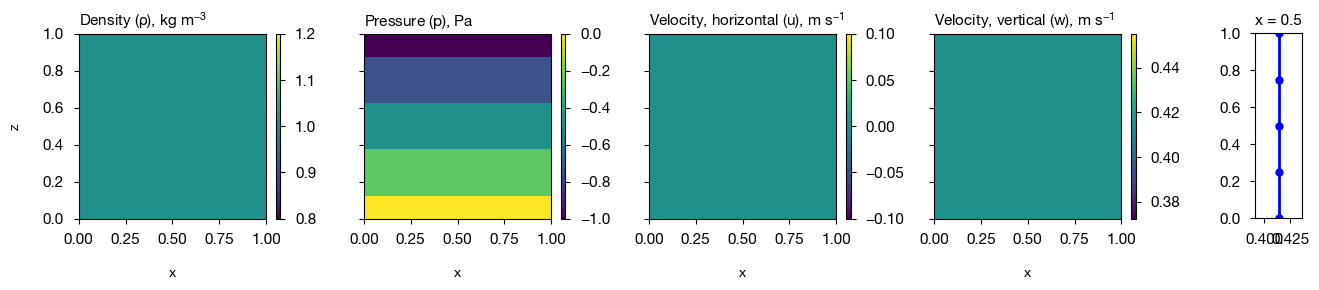

In [1428]:
field_plot([base_x, base_z], [rho, p, u, w], 4)

#### Field plots

In [1421]:
from mpl_toolkits.axes_grid1 import make_axes_locatable as ml
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def field_plot(grids, datasets, timestep=0):

    x, z = grids
    
    nrows, ncols = 1, len(datasets)
    fig, axs = plt.subplots(figsize=(3*ncols, 3*nrows), ncols=ncols, sharey=True)

    for i, data in enumerate(datasets):
        ax = axs[i]
        values = data['values'][:, :, timestep]

        if data['long_name'] == 'Density':
            vmin, vmax = [0.8, 1.2]
        else:
            vmin, vmax = [None, None]
            
        im = ax.pcolormesh(x, z, values, vmin=vmin, vmax=vmax)
        if data['long_name'] == 'Velocity, vertical':
            iax = inset_axes(ax, height='100%', width='25%', bbox_to_anchor=(1, 0.04, 1, 1), bbox_transform=ax.transAxes)
            center_i = len(x) // 2
            center_profile = iax.plot(values[:, center_i], z[:, center_i], marker='o')
            iax.set_ylim([0, 1])
            iax.set_title('x = {0:.1f}'.format(x[0, center_i]))
    
        # Axis properties
        ax.set_xlim([x.min(), x.max()])
        ax.set_ylim([z.min(), z.max()])
        # Axis title
        ax.set_xlabel('x')
        ax.set_ylabel('z') if i == 0 else None

        # Colorbar
        cax_width = 0.25*ax.get_position().width
        divider = ml(ax)
        cax = divider.append_axes('right', size=cax_width, pad=0.1)
        cb = fig.colorbar(im, cax=cax)
        

        # Metadata
        ax_title_str = r'{0} ({1}), {2}'.format(data['long_name'], data['name'], data['units'])
        ax.set_title(label=ax_title_str)
        
    fig.tight_layout()